### MIMIC CXR

* [Dataset](https://physionet.org/content/mimic-cxr/2.0.0/)

* [Original Paper](https://www.nature.com/articles/s41597-019-0322-0)

### Setup Environment:

In [1]:
import os
import pandas as pd

from src.classifiers import preprocess_data, process_labels,split_data

from src.classifiers import VQADataset
from torch.utils.data import DataLoader

from src.classifiers import train_early_fusion, train_late_fusion

In [2]:
PATH = 'Embeddings/mimic/'
COLUMN = 'embeddings'

In [3]:
text_path, images_path = 'text_embeddings.csv', 'Embeddings_dinov2_base.csv' # os.listdir(PATH)

## Get data

### Text

In [4]:
text = pd.read_csv(os.path.join(PATH, text_path))
text

,path,race_label,sex_label,disease_label,subject_id,study_id,split,file_path,image_id,embeddings
0,p19/p19702416/s51321189/d85c9f15-f0f84927-761f...,0,0,3,19702416,51321189,train,datasets/mimic/files/p19/p19702416/s51321189.txt,s51321189_d85c9f15-f0f84927-761f30e0-51c2d319-...,"[0.019312300477283984, -0.0168451968233965, 0...."
1,p13/p13339704/s51292704/0024603b-12db30e2-ab32...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,s51292704_0024603b-12db30e2-ab32c9cb-dae5a3fc-...,"[0.012197528503835167, -0.02721826380867521, -..."
2,p13/p13339704/s51292704/7953848d-2411f0df-859f...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,s51292704_7953848d-2411f0df-859f5cea-38c618e0-...,"[0.012197528503835167, -0.02721826380867521, -..."
3,p12/p12668169/s54048859/8a4aaaee-55fcf98f-a036...,0,0,3,12668169,54048859,train,datasets/mimic/files/p12/p12668169/s54048859.txt,s54048859_8a4aaaee-55fcf98f-a036a8e7-da71eed1-...,"[0.023151464746335323, -0.003735494237665375, ..."
4,p10/p10309415/s58144222/9886b0fe-9121c65e-c8d7...,0,0,3,10309415,58144222,train,datasets/mimic/files/p10/p10309415/s58144222.txt,s58144222_9886b0fe-9121c65e-c8d74649-4b88c530-...,"[0.022131832248893236, -0.02182131683603928, 0..."
...,...,...,...,...,...,...,...,...,...,...
153123,p14/p14476373/s53343726/f231fe18-30e5023f-617d...,0,0,0,14476373,53343726,val,datasets/mimic/files/p14/p14476373/s53343726.txt,s53343726_f231fe18-30e5023f-617d5710-b7343694-...,"[0.036062664090444306, -0.024110380535552218, ..."
153124,p12/p12491157/s54173393/6aa095e2-8ec1eeae-432f...,0,0,3,12491157,54173393,val,datasets/mimic/files/p12/p12491157/s54173393.txt,s54173393_6aa095e2-8ec1eeae-432fbe0a-951014ba-...,"[0.030613531621846417, -0.013087464989618098, ..."
153125,p14/p14036332/s52691805/f52e19e0-9569d75a-7c2e...,0,0,2,14036332,52691805,val,datasets/mimic/files/p14/p14036332/s52691805.txt,s52691805_f52e19e0-9569d75a-7c2e1cca-588fe579-...,"[0.022604879986884274, -0.008428466567363305, ..."
153126,p10/p10972527/s53691151/f4f75648-baff1e55-0086...,0,0,3,10972527,53691151,val,datasets/mimic/files/p10/p10972527/s53691151.txt,s53691151_f4f75648-baff1e55-0086d06c-cf27d72e-...,"[0.024008833012363645, -0.02083004001988949, -..."


### Images

In [5]:
images = pd.read_csv(os.path.join(PATH, images_path))
images.head()

,ImageName,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,s57038960_db65d2eb-898d82af-87f59617-9ef8f1b8-...,-0.436693,-1.049584,0.640005,0.415092,-1.940182,0.858519,1.777970,-1.704433,-1.516895,...,-1.786172,-0.321480,-2.379034,-0.091928,1.205125,-2.092803,-1.849968,-2.751856,1.281025,-2.946824
1,s54536642_fe1a39db-b20ab2f2-6259a4a2-8c5a2638-...,-0.160901,-0.433440,-0.650693,1.273812,-2.661967,0.785982,2.142300,-1.868585,0.007601,...,-2.072898,-0.098359,-2.855795,1.093558,0.400163,-1.812585,-2.146883,-3.329220,1.434818,-2.328356
2,s51004296_bc027209-0c889cc5-b7ff43bc-11b44b52-...,-0.641195,0.156166,0.047452,0.138009,-1.724101,0.282340,2.119441,-1.537461,0.017383,...,-1.727623,-0.923027,-3.364305,0.637478,1.279478,-2.412542,-2.311730,-2.821277,1.974853,-3.839996
3,s56486389_00bbcb53-1b59b3a1-64b2ad2c-f7e4bc9b-...,-1.125658,0.159419,-0.995158,0.303959,-2.738186,0.452527,2.212985,-3.260901,-0.094809,...,-1.979997,0.104396,-1.797872,0.355599,1.269172,-2.556092,-1.792497,-2.726921,1.786852,-2.403912
4,s56962831_eadb5bb3-0ecb52be-a031b685-c1558abc-...,-1.296178,-0.460473,-1.792543,0.311563,-2.836921,-0.110482,2.216610,-2.794921,-0.308835,...,-2.237700,-0.129795,-2.576111,0.355970,0.700511,-3.887913,-0.871856,-3.350262,1.592613,-2.709266


### Merge and preprocess the datasets

In [6]:
#df = preprocess_data(text, images, "image_id", "ImageName")
df = pd.read_csv('Embeddings/mimic/embeddings.csv')
df.disease_label = df.disease_label.astype(str)
#df.to_csv(os.path.join(PATH, 'embeddings.csv'), index=False)
df.head()

,path,race_label,sex_label,disease_label,subject_id,study_id,split,file_path,text_1,text_2,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,p19/p19702416/s51321189/d85c9f15-f0f84927-761f...,0,0,3,19702416,51321189,train,datasets/mimic/files/p19/p19702416/s51321189.txt,0.019312,-0.016845,...,-1.977094,0.664772,-2.003561,0.063048,0.218469,-2.259382,-1.804749,-3.272988,1.671752,-2.163086
1,p13/p13339704/s51292704/0024603b-12db30e2-ab32...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,0.012198,-0.027218,...,-2.502330,-0.262871,-2.777717,1.082299,1.273291,-1.900938,-1.250531,-3.238538,1.466622,-3.243235
2,p13/p13339704/s51292704/7953848d-2411f0df-859f...,2,0,3,13339704,51292704,train,datasets/mimic/files/p13/p13339704/s51292704.txt,0.012198,-0.027218,...,-2.352660,0.049591,-2.599992,0.709397,0.635155,-2.035155,-1.170720,-3.293882,1.306690,-2.955477
3,p12/p12668169/s54048859/8a4aaaee-55fcf98f-a036...,0,0,3,12668169,54048859,train,datasets/mimic/files/p12/p12668169/s54048859.txt,0.023151,-0.003735,...,-2.531913,0.778623,-3.406011,0.288661,1.660015,-2.785958,-1.350666,-2.999661,2.809513,-3.075176
4,p10/p10309415/s58144222/9886b0fe-9121c65e-c8d7...,0,0,3,10309415,58144222,train,datasets/mimic/files/p10/p10309415/s58144222.txt,0.022132,-0.021821,...,-1.868888,0.562119,-1.824777,0.069089,1.093687,-1.628035,-1.373444,-3.014874,1.524349,-2.403681


## Data Perparation

In [7]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'disease_label'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Train Shape: (107695, 4872)
Test Shape: (30360, 4872)


### Models

In [8]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
if label_columns == 'DR_2':
    output_size = 1
else:
    output_size = len(pd.unique(train_df[label_columns]))
multilabel = False

Training Early Fusion Model:
The number of parameters of the model are: 623492
Epoch 1/50 - Test Accuracy: 0.8006, macro-f1: 0.5516
Epoch 1/50 - Training Time: 9.06 seconds | Inference Time: 2.50 seconds
Epoch 2/50 - Test Accuracy: 0.6297, macro-f1: 0.5203
Epoch 2/50 - Training Time: 10.15 seconds | Inference Time: 2.66 seconds
Epoch 3/50 - Test Accuracy: 0.6738, macro-f1: 0.5448
Epoch 3/50 - Training Time: 9.13 seconds | Inference Time: 2.68 seconds
Epoch 4/50 - Test Accuracy: 0.6652, macro-f1: 0.5568
Epoch 4/50 - Training Time: 9.57 seconds | Inference Time: 3.37 seconds
Epoch 5/50 - Test Accuracy: 0.6822, macro-f1: 0.5508
Epoch 5/50 - Training Time: 9.25 seconds | Inference Time: 3.34 seconds
Epoch 6/50 - Test Accuracy: 0.6550, macro-f1: 0.5452
Epoch 6/50 - Training Time: 9.09 seconds | Inference Time: 2.78 seconds
Epoch 7/50 - Test Accuracy: 0.6241, macro-f1: 0.5157
Epoch 7/50 - Training Time: 9.25 seconds | Inference Time: 2.58 seconds
Epoch 8/50 - Test Accuracy: 0.7097, macro-f1:

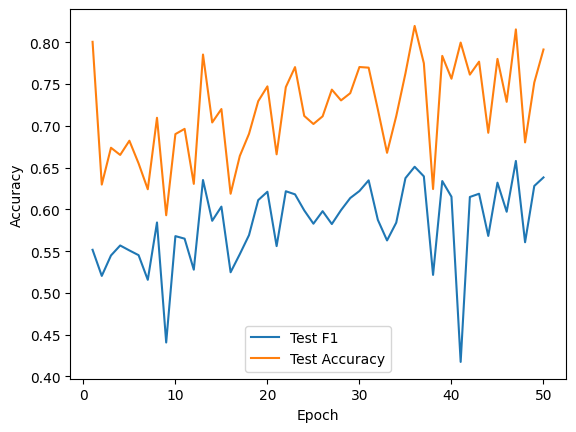

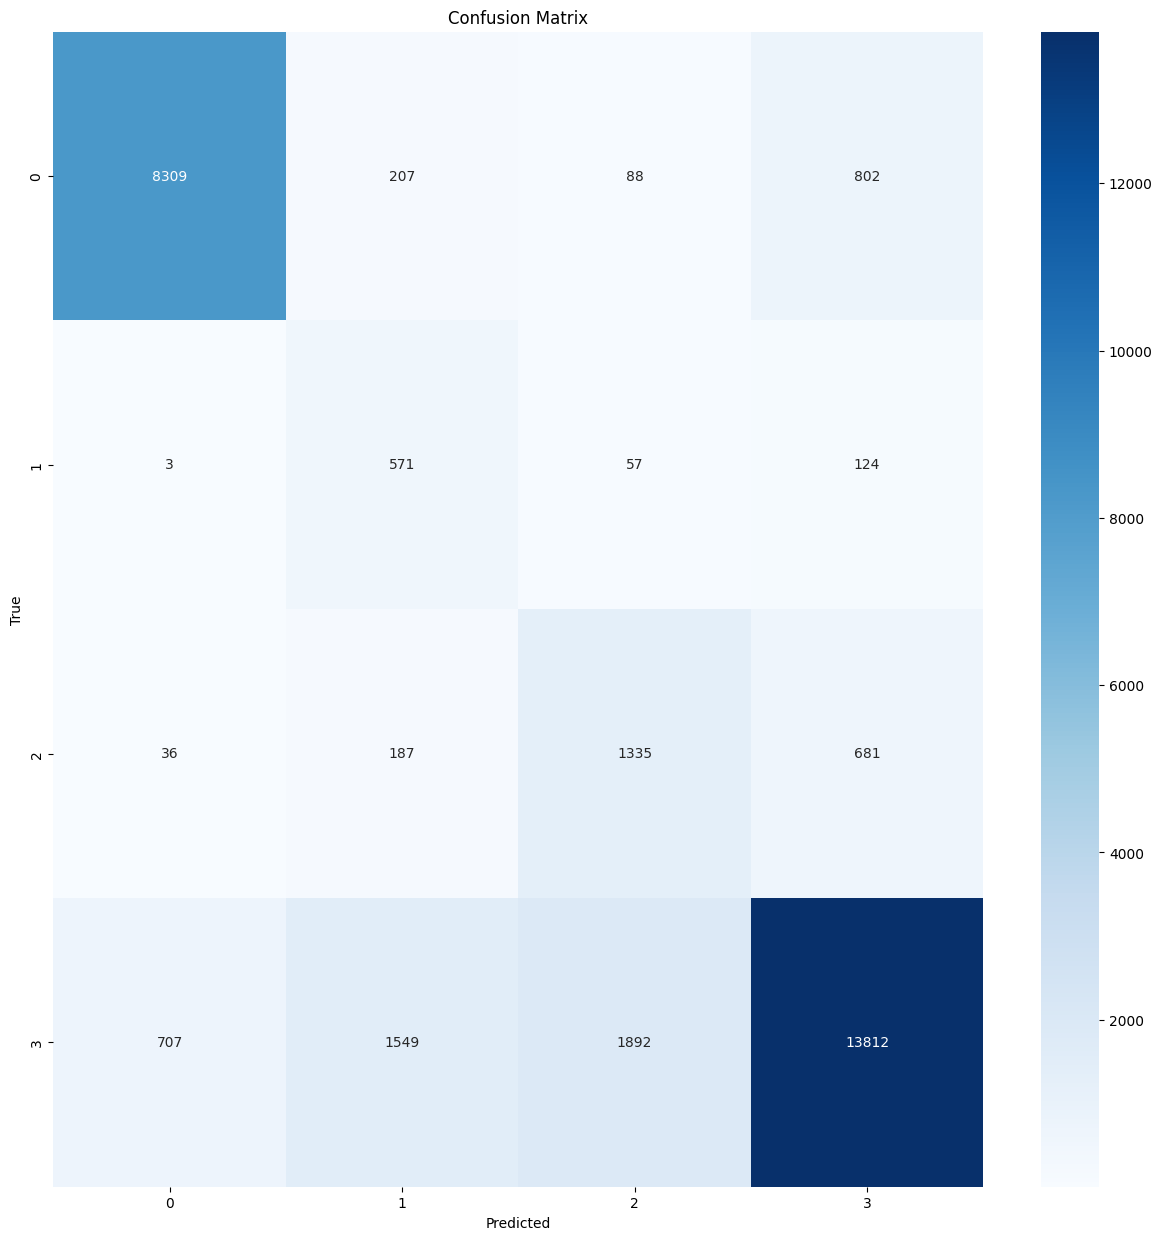

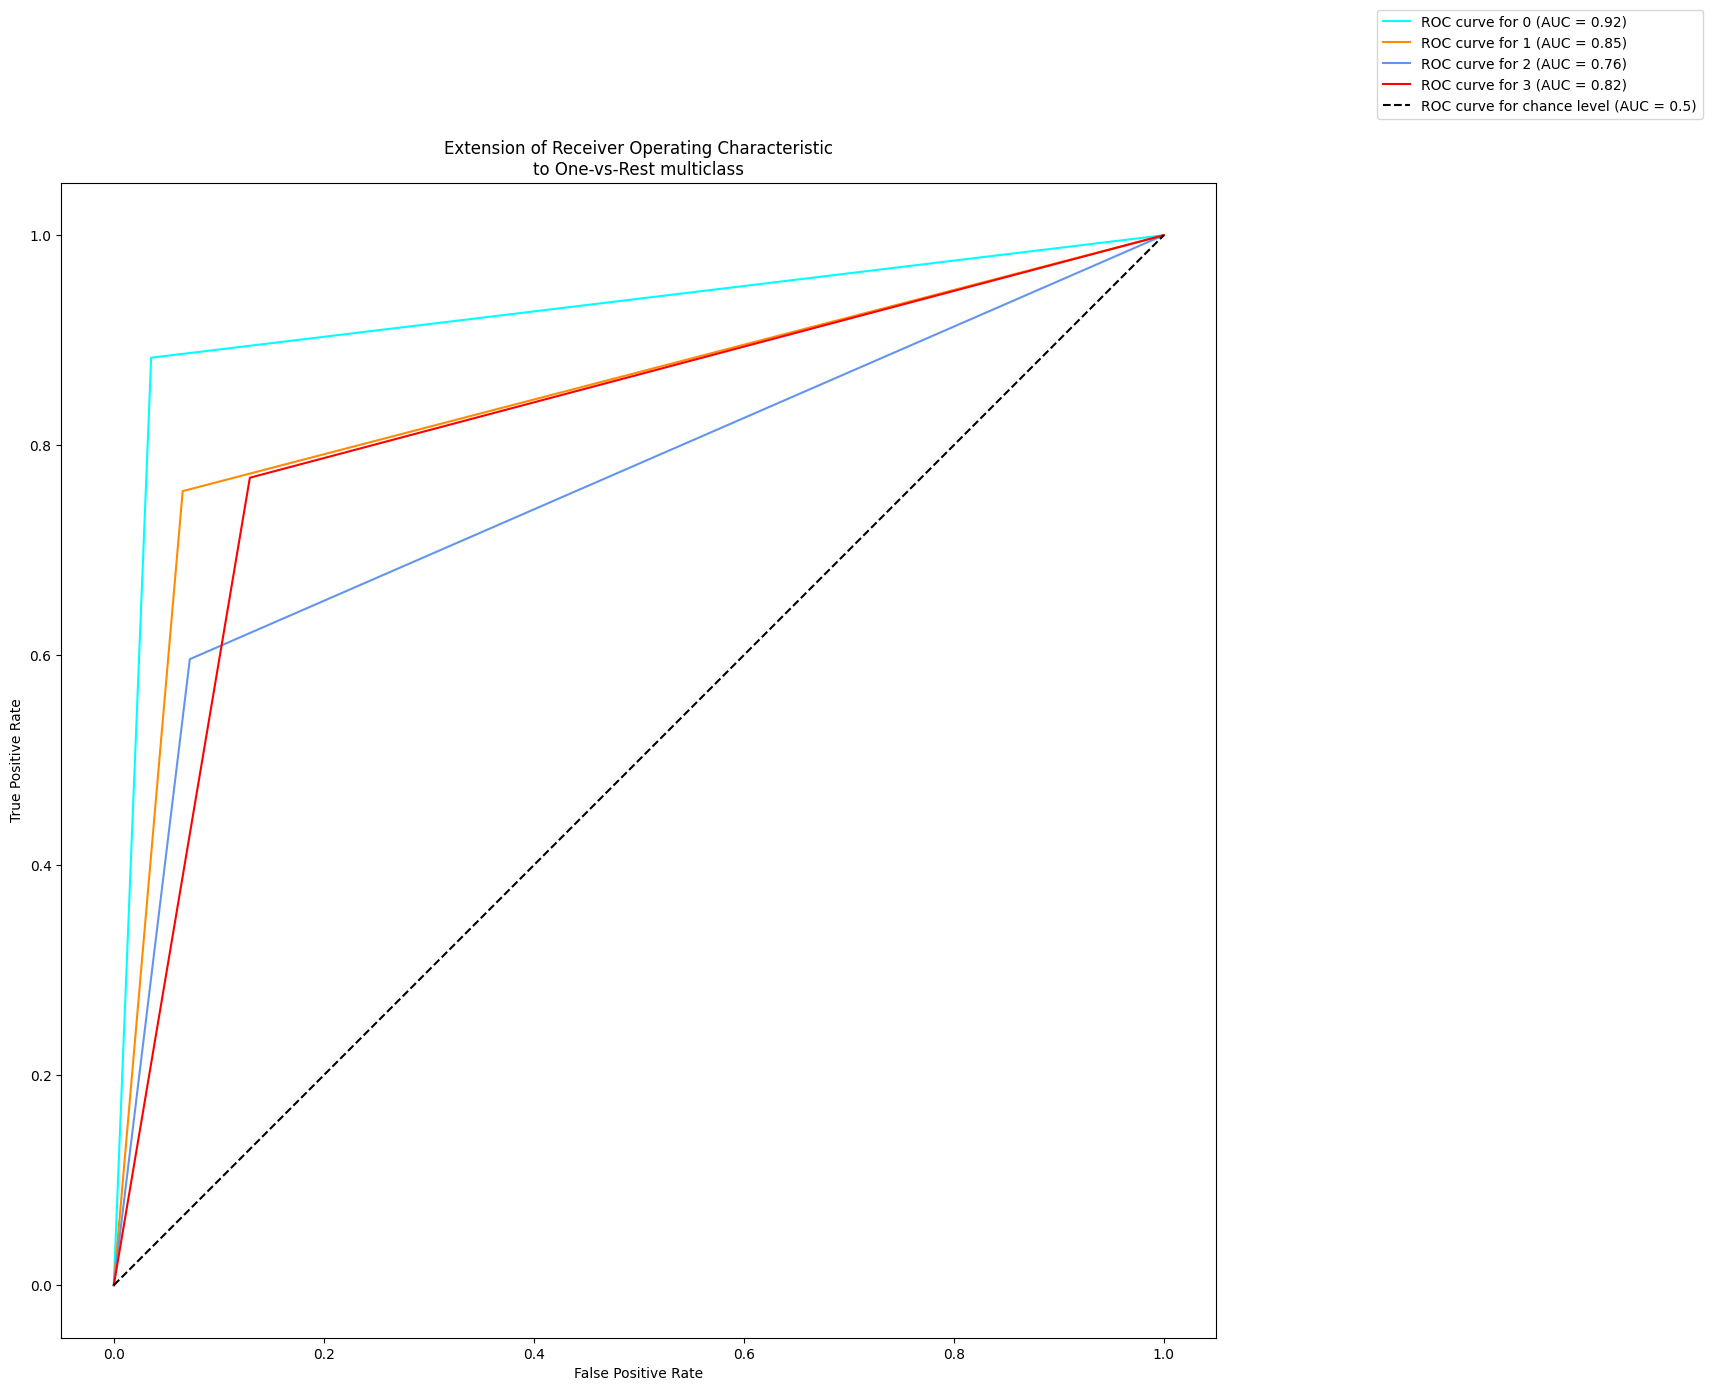

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      9406
           1       0.23      0.76      0.35       755
           2       0.40      0.60      0.48      2239
           3       0.90      0.77      0.83     17960

    accuracy                           0.79     30360
   macro avg       0.61      0.75      0.64     30360
weighted avg       0.85      0.79      0.81     30360



(0.791403162055336,
 0.8490504936794186,
 0.791403162055336,
 0.8122401710170777,
 {'Acc': {'Acc': 0.819631093544137, 'F1': 0.651014485161453, 'Epoch': 36},
  'Macro-F1': {'Acc': 0.8154808959156785,
   'F1': 0.6579599339754237,
   'Epoch': 47}})

In [9]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=50, multilabel=multilabel, report=True)

Training Late Fusion Model:
The number of parameters of the model are: 312196
Epoch 1/50 - Test Accuracy: 0.7411, macro-f1: 0.6056
Epoch 1/50 - Training Time: 8.36 seconds | Inference Time: 2.60 seconds
Epoch 2/50 - Test Accuracy: 0.7255, macro-f1: 0.5970
Epoch 2/50 - Training Time: 8.57 seconds | Inference Time: 2.64 seconds
Epoch 3/50 - Test Accuracy: 0.7305, macro-f1: 0.5965
Epoch 3/50 - Training Time: 8.54 seconds | Inference Time: 2.57 seconds
Epoch 4/50 - Test Accuracy: 0.7157, macro-f1: 0.6171
Epoch 4/50 - Training Time: 8.68 seconds | Inference Time: 2.57 seconds
Epoch 5/50 - Test Accuracy: 0.7894, macro-f1: 0.6461
Epoch 5/50 - Training Time: 8.70 seconds | Inference Time: 2.46 seconds
Epoch 6/50 - Test Accuracy: 0.8039, macro-f1: 0.6580
Epoch 6/50 - Training Time: 8.20 seconds | Inference Time: 2.63 seconds
Epoch 7/50 - Test Accuracy: 0.7714, macro-f1: 0.6356
Epoch 7/50 - Training Time: 8.54 seconds | Inference Time: 2.56 seconds
Epoch 8/50 - Test Accuracy: 0.7395, macro-f1: 0

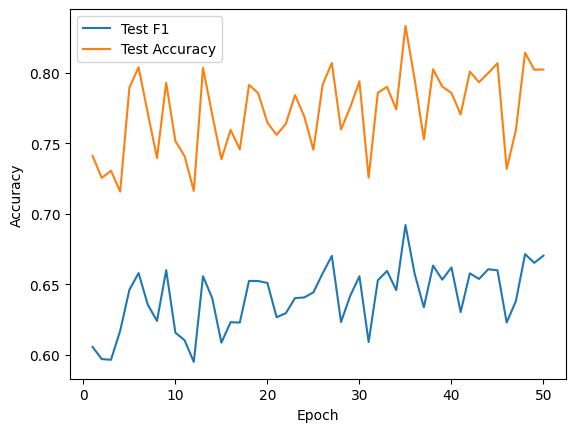

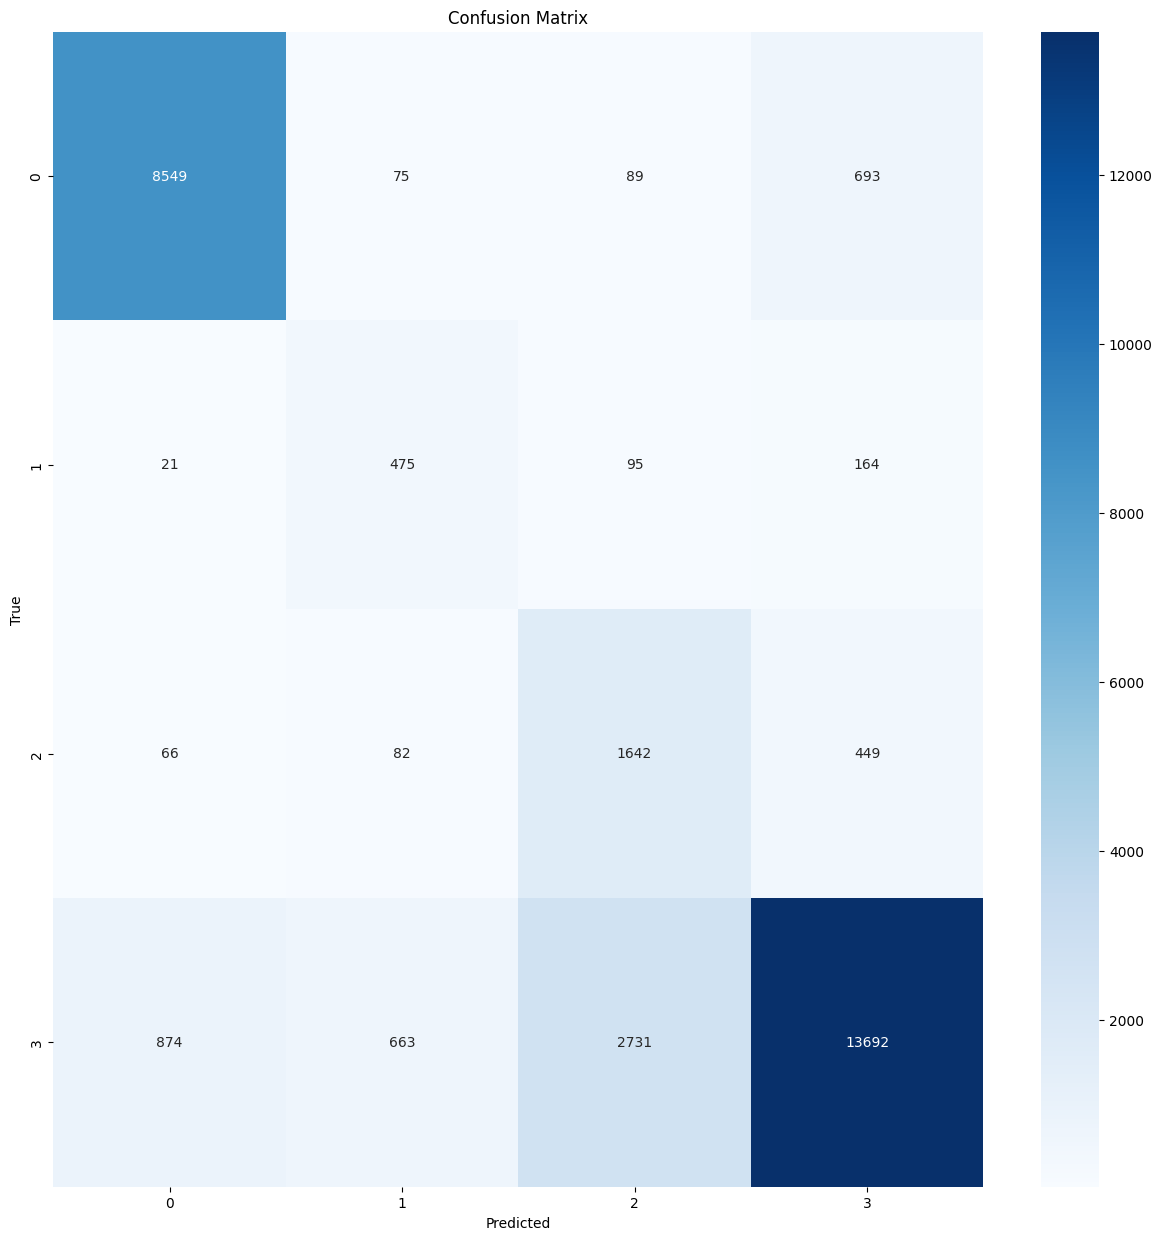

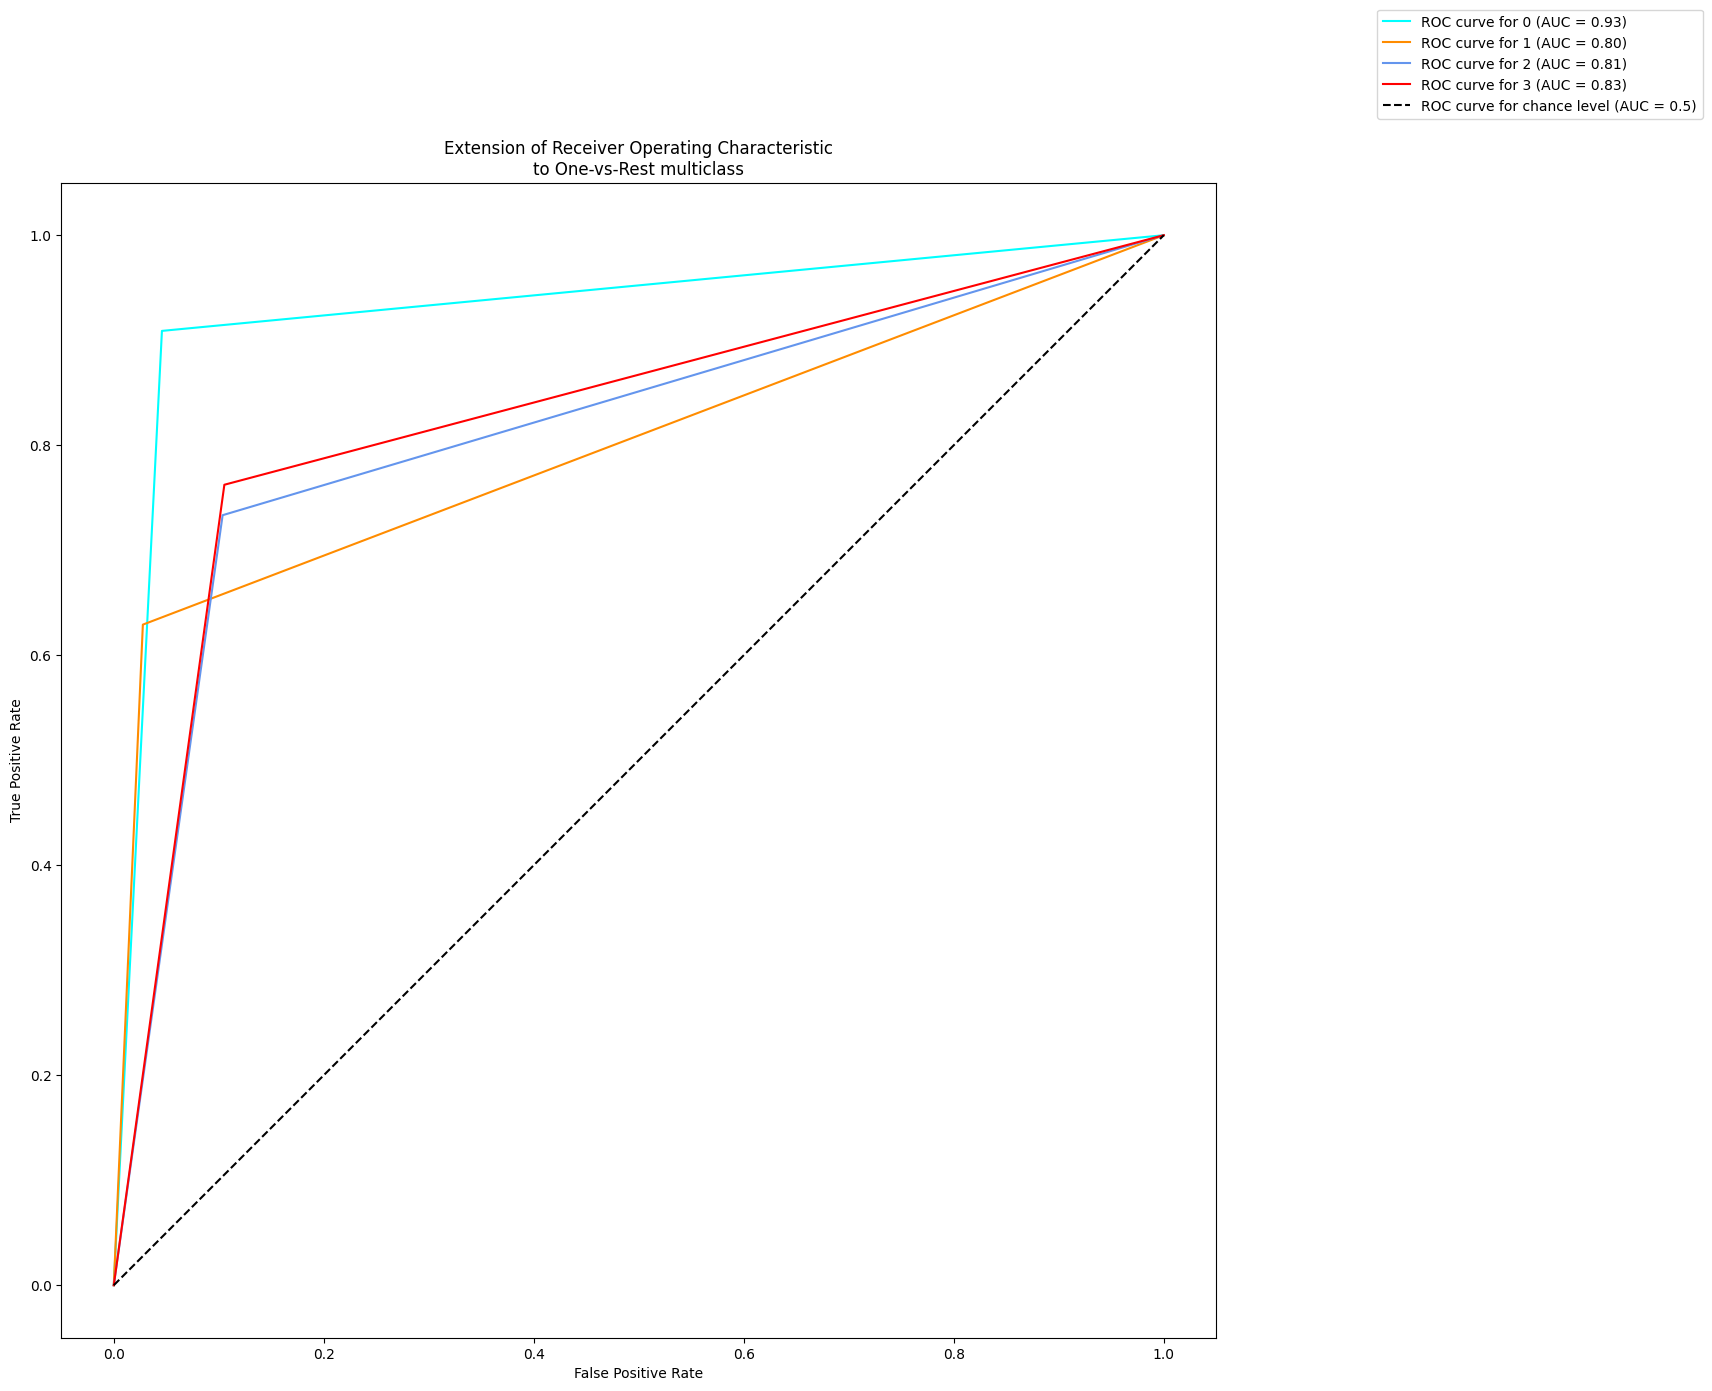

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      9406
           1       0.37      0.63      0.46       755
           2       0.36      0.73      0.48      2239
           3       0.91      0.76      0.83     17960

    accuracy                           0.80     30360
   macro avg       0.63      0.76      0.67     30360
weighted avg       0.85      0.80      0.82     30360



(0.8023056653491436,
 0.8542582732247762,
 0.8023056653491436,
 0.818720168165169,
 {'Acc': {'Acc': 0.833201581027668, 'F1': 0.6920466303575877, 'Epoch': 35},
  'Macro-F1': {'Acc': 0.833201581027668,
   'F1': 0.6920466303575877,
   'Epoch': 35}})

In [10]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=50, multilabel=multilabel, report=True)